In [4]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, norm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

GT_DIR = '/path/to/your/input/data/directory/'
GEN_DIR = '/path/to/your/output/data/directory/'

CXR_LABELS_1 = ["Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion", 
"Lung Opacity", "Edema", "Consolidation", "Pneumonia", 
"Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"] # without "No Finding"

In [5]:
import warnings
warnings.filterwarnings('ignore')

## 1. Prepare Data

Exclude "No Finding"

In [6]:
df_gen = pd.read_csv(GEN_DIR+'gen_labels_sample_2_1.csv').sort_values(by='study_id').reset_index(drop=True) ## 2-class
df_gen.dropna(inplace=True)
df_gen.shape

(300, 15)

In [7]:
df_gt = pd.read_csv(GT_DIR+"gt_labels_sample.csv").sort_values(by='study_id').reset_index(drop=True)
df_gt.dropna(inplace=True)
df_gt.shape

(300, 15)

In [8]:
df_gt = df_gt[df_gt['study_id'].isin(df_gen['study_id'])]
df_gt.shape

(300, 15)

In [9]:
df_temp = df_gt.drop(columns=["study_id", "No Finding"])
df_temp.columns == CXR_LABELS_1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [10]:
# GT label distribution
df = df_gt.drop(columns=['study_id'])
df_counts = pd.DataFrame(columns=CXR_LABELS_1)

for col in CXR_LABELS_1:
    temp = df[col].value_counts()
    df_counts[col] = temp

df_counts = df_counts.fillna(0).T
df_counts.rename(columns={2: 'unmentioned', 1: 'positive', 0: 'negative', -1: 'uncertain'}, inplace=True)
df_counts_gt = df_counts[['positive', 'negative', 'uncertain', 'unmentioned']]
df_counts_gt['Pr(pos)'] = df_counts_gt['positive'] / 300
df_counts_gt

,positive,negative,uncertain,unmentioned,Pr(pos)
Enlarged Cardiomediastinum,10.0,4.0,14.0,272.0,0.033333
Cardiomegaly,52.0,17.0,13.0,218.0,0.173333
Lung Lesion,5.0,2.0,2.0,291.0,0.016667
Lung Opacity,60.0,1.0,1.0,238.0,0.200000
Edema,35.0,42.0,15.0,208.0,0.116667
Consolidation,10.0,17.0,5.0,268.0,0.033333
Pneumonia,7.0,37.0,24.0,232.0,0.023333
Atelectasis,57.0,1.0,14.0,228.0,0.190000
Pneumothorax,7.0,45.0,3.0,245.0,0.023333
Pleural Effusion,65.0,30.0,3.0,202.0,0.216667


In [ ]:
# GT label distribution (control each condition)
Top_5 = ["Edema", "Consolidation", "Pneumonia", "Pneumothorax", "Pleural Effusion"]
ls_gt_corr = []
df_gt_corr = pd.DataFrame(columns=CXR_LABELS_1)
df_contingency_gt = pd.DataFrame(columns=CXR_LABELS_1)
for i in range(len(CXR_LABELS_1)):

    df = df_gt.drop(columns=['study_id'])
    df = df[df[CXR_LABELS_1[i]] == 1]

    df_counts = pd.DataFrame(index=[0, 1, 2, -1], columns=CXR_LABELS_1).fillna(0)

    for lbl in CXR_LABELS_1:
        temp = df[lbl].value_counts()
        df_counts.loc[temp.index, lbl] = temp
    

    df_counts = df_counts.fillna(0).T
    df_counts.rename(columns={2: 'unmentioned', 1: 'positive', 0: 'negative', -1: 'uncertain'}, inplace=True)
   
    df_counts_gt_e = df_counts[['positive', 'negative', 'uncertain', 'unmentioned']]
    df_counts_gt_e['Pr(pos)'] = df_counts_gt_e['positive'] / (df_counts_gt_e['positive']+df_counts_gt_e['negative']+df_counts_gt_e['uncertain']+df_counts_gt_e['unmentioned'])
    
    ls_gt = df_counts_gt['Pr(pos)']
    ls_e = df_counts_gt_e['Pr(pos)']
    ls_gt_corr.append(ls_gt.corr(ls_e))
    df_gt_corr[CXR_LABELS_1[i]] = ls_e
    df_contingency_gt[CXR_LABELS_1[i]] = df_counts_gt_e['positive']
    print(CXR_LABELS_1[i], ls_gt.corr(ls_e))

df_gt_corr['Overall'] = ls_gt


Enlarged Cardiomediastinum 0.3807019610845607
Cardiomegaly 0.7551247571211428
Lung Lesion -0.06447654203824263
Lung Opacity 0.7380621835246968
Edema 0.5994327059218306
Consolidation 0.24949763328213098
Pneumonia 0.07515150906647633
Atelectasis 0.753291453622638
Pneumothorax 0.1486787355393764
Pleural Effusion 0.8373212330813224
Pleural Other 0.0541163005918278
Fracture 0.002534932674654534
Support Devices 0.8192110795122701


In [ ]:
# GEN label distribution
Top_5 = ["Edema", "Consolidation", "Pneumonia", "Pneumothorax", "Pleural Effusion"]
df = df_gen.drop(columns=['study_id'])
df_counts = pd.DataFrame(columns=CXR_LABELS_1)

for col in CXR_LABELS_1:
    temp = df[col].value_counts()
    df_counts[col] = temp

df_counts = df_counts.fillna(0).T
df_counts.rename(columns={1: 'positive', 0: 'other'}, inplace=True)
df_counts_gen_2_o = df_counts[['positive', 'other']]
df_counts_gen_2_o['Pr(pos)'] = df_counts_gen_2_o['positive'] / (df_counts_gen_2_o['positive']+df_counts_gen_2_o['other'])
df_counts_gen_2_o

,positive,other,Pr(pos)
Enlarged Cardiomediastinum,53.0,247.0,0.176667
Cardiomegaly,94.0,206.0,0.313333
Lung Lesion,3.0,297.0,0.010000
Lung Opacity,190.0,110.0,0.633333
Edema,61.0,239.0,0.203333
Consolidation,79.0,221.0,0.263333
Pneumonia,51.0,249.0,0.170000
Atelectasis,48.0,252.0,0.160000
Pneumothorax,3.0,297.0,0.010000
Pleural Effusion,127.0,173.0,0.423333


In [ ]:
# Gen label distribution (control each condition)
Top_5 = ["Edema", "Consolidation", "Pneumonia", "Pneumothorax", "Pleural Effusion"]
ls_gen_corr = []
df_corr = pd.DataFrame(columns=CXR_LABELS_1)
df_contingency_gen = pd.DataFrame(columns=CXR_LABELS_1)
for i in range(len(CXR_LABELS_1)):
    df = df_gen.copy()
    df = df_gen[df_gen['study_id'].isin(df_gt[df_gt[CXR_LABELS_1[i]] == 1]['study_id'])]
    df = df.drop(columns=['study_id'])

    df_counts = pd.DataFrame(index=[0, 1, 2, -1], columns=CXR_LABELS_1).fillna(0)

    for lbl in CXR_LABELS_1:
        temp = df[lbl].value_counts()
        df_counts.loc[temp.index, lbl] = temp
    

    df_counts = df_counts.fillna(0).T
    df_counts.rename(columns={1: 'positive', 0: 'other'}, inplace=True)
    df_counts_gen_e = df_counts[['positive', 'other']]
    df_counts_gen_e['Pr(pos)'] = df_counts_gen_e['positive'] / (df_counts_gen_e['positive']+df_counts_gen_e['other'])
    
    ls_gen = df_counts_gen_2_o['Pr(pos)']
    ls_e = df_counts_gen_e['Pr(pos)']
    ls_gen_corr.append(ls_gen.corr(ls_e))
    df_corr[CXR_LABELS_1[i]] = ls_e
    df_contingency_gen[CXR_LABELS_1[i]] = df_counts_gen_e['positive']
    print(CXR_LABELS_1[i], ls_gen.corr(ls_e))

df_corr['Overall'] = ls_gen

Enlarged Cardiomediastinum 0.9408321619663139
Cardiomegaly 0.9871629384593105
Lung Lesion 0.7864779827174827
Lung Opacity 0.993847741699377
Edema 0.9878944131974725
Consolidation 0.9766567241636148
Pneumonia 0.8713263440694861
Atelectasis 0.9850870536793017
Pneumothorax 0.9492209489345866
Pleural Effusion 0.9867700803881179
Pleural Other 0.5713820464503786
Fracture 0.9347990284510099
Support Devices 0.9762708045898871


# 2. Check Group Overlap Issue

In [15]:
df_gt_2 = df_gt.drop(columns=['study_id'])
df_gt_2.replace(-1, 0, inplace=True)
df_gt_2.replace(2, 0, inplace=True)

df_contingency_matrices = pd.DataFrame(index=CXR_LABELS_1, columns=CXR_LABELS_1)

for i in range(len(CXR_LABELS_1)):
    for j in range(len(CXR_LABELS_1)):
        if i == j:
            df_contingency_matrices.loc[CXR_LABELS_1[i], CXR_LABELS_1[j]] = df_gt_2[CXR_LABELS_1[i]].sum()
        else:
            contingency_matrix = pd.crosstab(df_gt_2[CXR_LABELS_1[i]], df_gt_2[CXR_LABELS_1[j]])
            df_contingency_matrices.loc[CXR_LABELS_1[i], CXR_LABELS_1[j]] = contingency_matrix.get(1, {}).get(1, 0)

df_contingency_matrices

,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
Enlarged Cardiomediastinum,10,2,0,5,2,0,0,2,0,3,0,0,5
Cardiomegaly,2,52,0,13,16,1,1,16,2,24,0,1,23
Lung Lesion,0,0,5,1,0,0,0,1,0,1,0,0,0
Lung Opacity,5,13,1,60,7,1,3,21,2,20,1,1,20
Edema,2,16,0,7,35,3,0,8,0,18,1,0,13
Consolidation,0,1,0,1,3,10,1,3,0,4,0,0,4
Pneumonia,0,1,0,3,0,1,7,0,0,1,0,0,2
Atelectasis,2,16,1,21,8,3,0,57,2,22,0,2,18
Pneumothorax,0,2,0,2,0,0,0,2,7,1,0,1,2
Pleural Effusion,3,24,1,20,18,4,1,22,1,65,0,1,27


In [16]:
# Calculate the ratio table
df_ratio_table = df_contingency_matrices.copy()
for i in range(len(df_contingency_matrices)):
    diagonal_value = df_contingency_matrices.iloc[i, i]
    df_ratio_table.iloc[i] = (df_contingency_matrices.iloc[i] / diagonal_value).apply(lambda x: round(x, 2))
    df_ratio_table.iloc[i, i] = pd.NA

print(df_ratio_table.stack().mean())
df_ratio_table

0.13153846153846155


,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
Enlarged Cardiomediastinum,<NA>,0.2,0.0,0.5,0.2,0.0,0.0,0.2,0.0,0.3,0.0,0.0,0.5
Cardiomegaly,0.04,<NA>,0.0,0.25,0.31,0.02,0.02,0.31,0.04,0.46,0.0,0.02,0.44
Lung Lesion,0.0,0.0,<NA>,0.2,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0
Lung Opacity,0.08,0.22,0.02,<NA>,0.12,0.02,0.05,0.35,0.03,0.33,0.02,0.02,0.33
Edema,0.06,0.46,0.0,0.2,<NA>,0.09,0.0,0.23,0.0,0.51,0.03,0.0,0.37
Consolidation,0.0,0.1,0.0,0.1,0.3,<NA>,0.1,0.3,0.0,0.4,0.0,0.0,0.4
Pneumonia,0.0,0.14,0.0,0.43,0.0,0.14,<NA>,0.0,0.0,0.14,0.0,0.0,0.29
Atelectasis,0.04,0.28,0.02,0.37,0.14,0.05,0.0,<NA>,0.04,0.39,0.0,0.04,0.32
Pneumothorax,0.0,0.29,0.0,0.29,0.0,0.0,0.0,0.29,<NA>,0.14,0.0,0.14,0.29
Pleural Effusion,0.05,0.37,0.02,0.31,0.28,0.06,0.02,0.34,0.02,<NA>,0.0,0.02,0.42


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


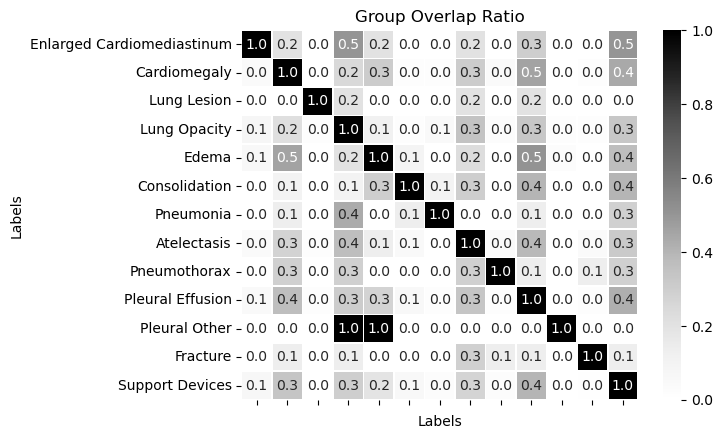

In [17]:
df_ratio_table = df_ratio_table.fillna(1)

sns.heatmap(df_ratio_table, annot=True, cmap='Greys', fmt=".1f", linewidths=.5)
plt.title('Group Overlap Ratio')
plt.xlabel('Labels')
plt.ylabel('Labels')
plt.gca().set_xticklabels([])

plt.show()

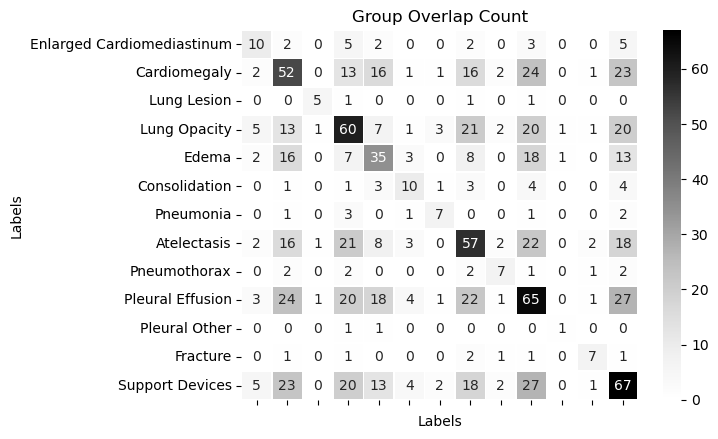

In [18]:
df_contingency_matrices = df_contingency_matrices.fillna(0).astype(int)

sns.heatmap(df_contingency_matrices, annot=True, cmap='Greys', fmt="d", linewidths=.5)
plt.title('Group Overlap Count')
plt.xlabel('Labels')
plt.ylabel('Labels')
plt.gca().set_xticklabels([])

plt.show()

# 3. Chi-square Test

## Method 1: Replace zero value with a very small value

In [22]:
# large scale would cause the higher magnitude of chi-square statistic, leading to spurious rejection of null hypothesis
df_temp_gt = (df_contingency_gt*1000+1)/1000
chi2, p, dof, expected = chi2_contingency(df_temp_gt)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

df_temp_gen = (df_contingency_gen*1000+1)/1000
chi2, p, dof, expected = chi2_contingency(df_temp_gen)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

Chi-square Statistic: 1770.3807917073586
P-value: 8.182797696116892e-278
df: 144
Chi-square Statistic: 66.05259302481171
P-value: 0.9999999969411394
df: 144


## Method 2: Drop zero values

In [23]:
ls_condition = ['Cardiomegaly', 'Edema', 'Lung Opacity', 'Atelectasis', 'Pleural Effusion', "Support Devices"] # Top 6 conditions in subsample

In [24]:
df_temp = df_contingency_gt[ls_condition]
df_temp_gt = df_temp[df_contingency_gt.index.isin(ls_condition)]

df_temp = df_contingency_gen[ls_condition]
df_temp_gen = df_temp[df_contingency_gen.index.isin(ls_condition)]

In [25]:
chi2, p, dof, expected = chi2_contingency(df_temp_gt)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

chi2, p, dof, expected = chi2_contingency(df_temp_gen)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

Chi-square Statistic: 317.8608472683398
P-value: 1.5397305563780617e-52
df: 25
Chi-square Statistic: 8.706653591477078
P-value: 0.9989415769128784
df: 25


# 4. Bootstrap CI

In [26]:
def bootstrap_confidence_interval(df, num_bootstrap_samples=1000, ci=95):
    bootstrap_samples = []
    # Resampling with replacement and computing the statistic of interest
    for _ in range(num_bootstrap_samples):
        idx = np.random.choice(df.shape[0], size=df.shape[0], replace=True)
        df_bootstrap = df[df.index.isin(idx)]
        df_bootstrap_con = df_bootstrap[df_bootstrap['gt']==1]
        Pr_pos_con = sum(df_bootstrap_con['gen']==1) / df_bootstrap_con.shape[0]
        Pr_pos = sum(df_bootstrap['gen']==1) / df_bootstrap.shape[0]
        bootstrap_samples.append(Pr_pos_con-Pr_pos)

    # Calculating the confidence interval
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    confidence_lower = round(np.percentile(bootstrap_samples, lower_percentile), 3)
    confidence_upper = round(np.percentile(bootstrap_samples, upper_percentile), 3)
    
    return confidence_lower, confidence_upper, bootstrap_samples


In [27]:
# deal with zero division
dict_ci = {}

for i in range(len(ls_condition)):
    df_temp = pd.DataFrame(columns=['gt', 'gen'])
    df_temp['gt'] = df_gt[ls_condition[i]] # subgroup i
    dict_ci[ls_condition[i]] = {'labels': [], 'ci': []}
    for j in range(len(ls_condition)):
        if ls_condition[i] == ls_condition[j]:
            continue
        df_temp['gen'] = df_gen[ls_condition[j]]
        ci_lower, ci_upper, _ = bootstrap_confidence_interval(df_temp, 1000, 95)
        dict_ci[ls_condition[i]]['labels'].append(ls_condition[j])
        dict_ci[ls_condition[i]]['ci'].append((ci_lower, ci_upper))
        print(f"95% Confidence Interval of {ls_condition[i]} and {ls_condition[j]}: [{ci_lower}, {ci_upper}]")
    print('----------------------------------------')


95% Confidence Interval of Cardiomegaly and Edema: [0.106, 0.3]
95% Confidence Interval of Cardiomegaly and Lung Opacity: [0.208, 0.336]
95% Confidence Interval of Cardiomegaly and Atelectasis: [-0.009, 0.151]
95% Confidence Interval of Cardiomegaly and Pleural Effusion: [0.054, 0.246]
95% Confidence Interval of Cardiomegaly and Support Devices: [0.187, 0.303]
----------------------------------------
95% Confidence Interval of Edema and Cardiomegaly: [-0.03, 0.201]
95% Confidence Interval of Edema and Lung Opacity: [0.254, 0.382]
95% Confidence Interval of Edema and Atelectasis: [-0.042, 0.166]
95% Confidence Interval of Edema and Pleural Effusion: [0.212, 0.438]
95% Confidence Interval of Edema and Support Devices: [0.223, 0.33]
----------------------------------------
95% Confidence Interval of Lung Opacity and Cardiomegaly: [-0.059, 0.101]
95% Confidence Interval of Lung Opacity and Edema: [-0.028, 0.128]
95% Confidence Interval of Lung Opacity and Atelectasis: [-0.026, 0.103]
95% C

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


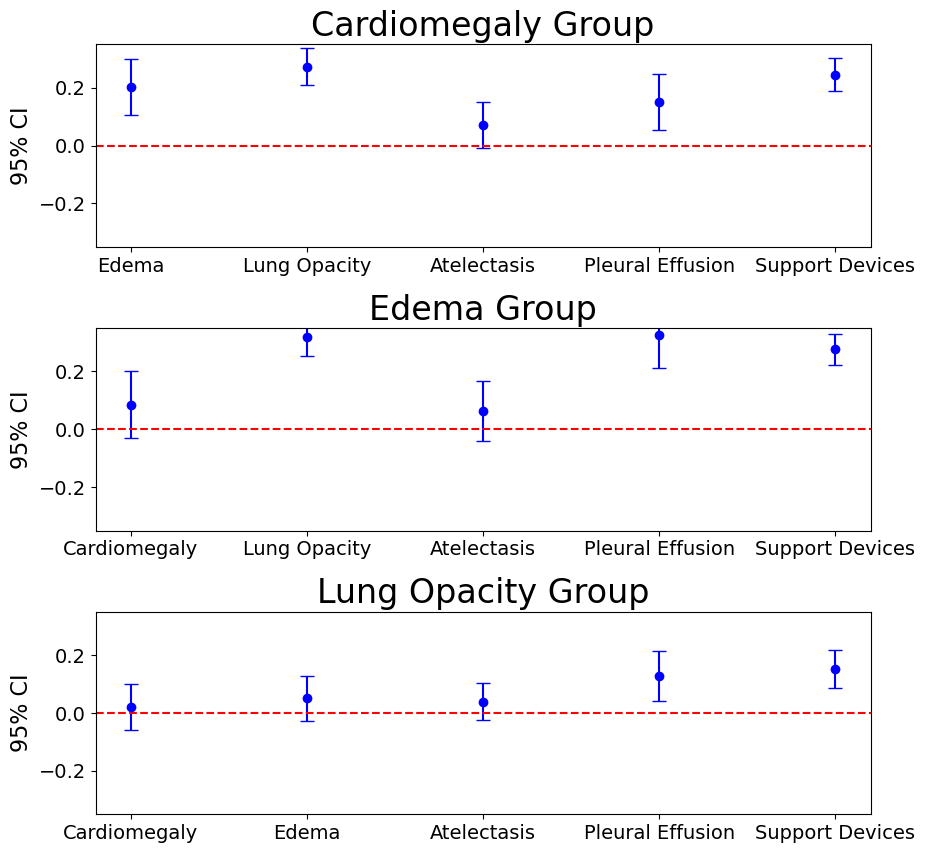

In [28]:
data = {k: dict_ci[k] for k in list(dict_ci)[:3]}

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for idx, (condition, values) in enumerate(data.items()):
    labels = values['labels']
    ci_lower = [ci[0] for ci in values['ci']]
    ci_upper = [ci[1] for ci in values['ci']]
    y_pos = range(len(labels))

    axs[idx].errorbar(labels, [(l+u)/2 for l, u in zip(ci_lower, ci_upper)], 
                      yerr=[[abs(l-(l+u)/2) for l, u in zip(ci_lower, ci_upper)], 
                            [u-(l+u)/2 for l, u in zip(ci_lower, ci_upper)]], 
                      fmt='o', capsize=5, color='blue')
    
    axs[idx].set_title(f'{condition} Group', fontsize=24)
    axs[idx].axhline(y=0, color='red', linestyle='--')
    axs[idx].set_ylabel('95% CI', fontsize=16)
    axs[idx].set_ylim(-0.35, 0.35)
    axs[idx].tick_params(axis='both', which='major', labelsize=14)

plt.subplots_adjust(hspace=0.4)
plt.show()


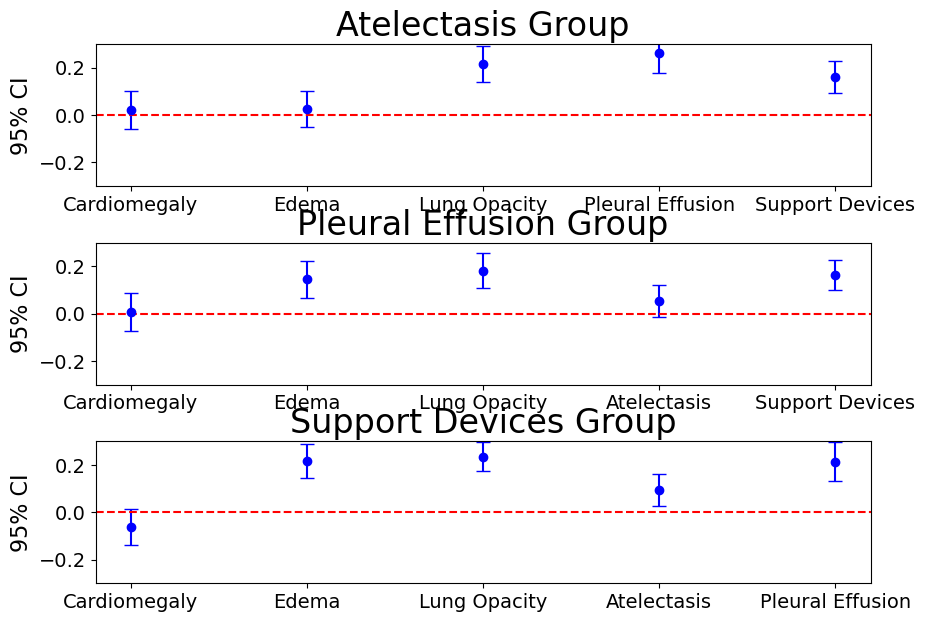

In [29]:
data = {k: dict_ci[k] for k in list(dict_ci)[3:]}

fig, axs = plt.subplots(3, 1, figsize=(10, 7))

for idx, (condition, values) in enumerate(data.items()):
    labels = values['labels']
    ci_lower = [ci[0] for ci in values['ci']]
    ci_upper = [ci[1] for ci in values['ci']]
    y_pos = range(len(labels))

    axs[idx].errorbar(labels, [(l+u)/2 for l, u in zip(ci_lower, ci_upper)], 
                      yerr=[[abs(l-(l+u)/2) for l, u in zip(ci_lower, ci_upper)], 
                            [u-(l+u)/2 for l, u in zip(ci_lower, ci_upper)]], 
                      fmt='o', capsize=5, color='blue')
    
    axs[idx].set_title(f'{condition} Group', fontsize=24)
    axs[idx].axhline(y=0, color='red', linestyle='--')
    axs[idx].set_ylabel('95% CI', fontsize=16)
    axs[idx].set_ylim(-0.3, 0.3)
    axs[idx].tick_params(axis='both', which='major', labelsize=14)

plt.subplots_adjust(hspace=0.4)
plt.show()

# 4. Correlation Test

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


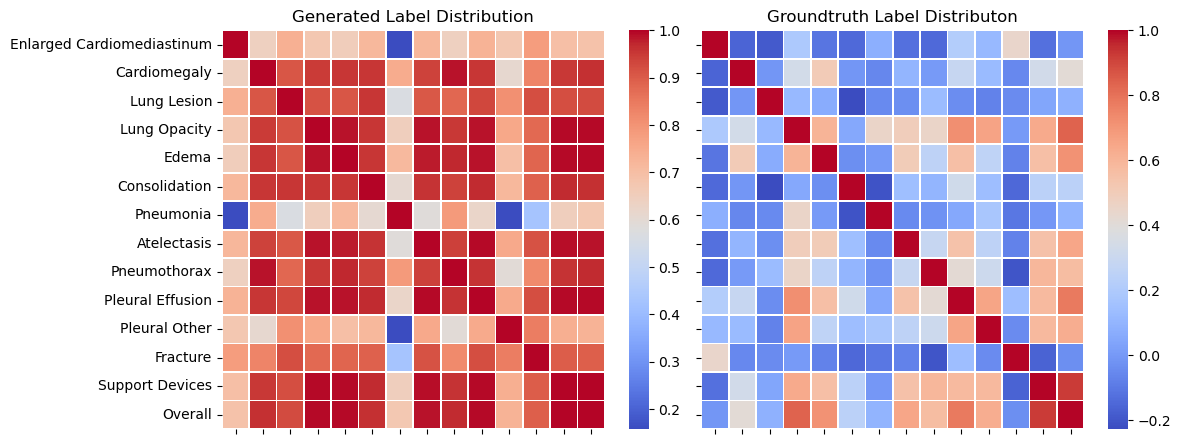

In [20]:
corr_matrix1 = df_corr.corr()
corr_matrix2 = df_gt_corr.corr()

# Set up a matplotlib figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# First heatmap
sns.heatmap(corr_matrix1, ax=ax1, annot=False, cmap='coolwarm', fmt=".1f", linewidths=.5)
ax1.set_title('Generated Label Distribution')
ax1.set_xticklabels([])
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Second heatmap
sns.heatmap(corr_matrix2, ax=ax2, annot=False, cmap='coolwarm', fmt=".1f", linewidths=.5)
ax2.set_title('Groundtruth Label Distributon')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Adjust layout
plt.tight_layout()
plt.show()